In [1]:
# Imports

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

I read in the data from the combined CSV which was created in my EDA notebook.

In [2]:
df = pd.read_csv('../data/joined_wallstreetbets_investing.csv')
df.drop(columns=['Unnamed: 0', 'index'], inplace=True)

I set the X feature, the y target, and perform a split for training and testing data. I then printed out the baseline accuracy score to determine what percentage I would have to improve upon if I were to only predict the majority class (50.4%).

In [3]:
X = df['combined']
y = df['sub_target']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=42)

# Print baseline accuracy
print(f'Baseline accuracy:\n{y_validation.value_counts(normalize=True)}')

Baseline accuracy:
1    0.504129
0    0.495871
Name: sub_target, dtype: float64


I created my own list of stopwords based on the most common words from my EDA (after removing stopwords). I also saved the NLTK stopwords to a variable so I could grid search through these stopwords as well as the default 'english' stopwords included with the vectorizers.

In [4]:
own_stopwords = ['amp', 'x200b', 'fintel', 'io', 'https', 'www', 'http', 'com', 
                 'wallstreetbets', 'reddit', 'restrict_sr', 'gt', 'flair', 'web']
nltk_stopwords = stopwords.words('english')

## Multinomial Naive Bayes

The first model I chose to run was the Multinomial Naive Bayes. I first established the parameters I wanted to evaluate with my grid search. I then established the pipeline with a vectorizer and the Multinomial NB model. I tested both the CountVectorizer and the TfidfVectorizer, but decided on using the CountVectorizer in conjunction with this model. I then set up my grid search utilizing 5 cross folds and used half of the cores of my computer to speed up processing.

In [5]:
mnb_pipe_params = {'vec__stop_words': [own_stopwords],
                  'vec__max_features': [36000],
                  'vec__min_df': [2],
                  'vec__max_df': [0.90],
                  'vec__ngram_range': [(1, 2)]}

mnb_pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

mnb_gs = GridSearchCV(mnb_pipe,
          mnb_pipe_params,
          cv=5,
          n_jobs=6,
          verbose=1)

I then fit my model using the above grid search and printed out my selection of best parameters and the best score.

In [6]:
mnb_gs.fit(X_train, y_train)

print(f'Best parameters: {mnb_gs.best_params_}')
print(f'Best score: {mnb_gs.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.1s finished


Best parameters: {'vec__max_df': 0.9, 'vec__max_features': 36000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2), 'vec__stop_words': ['amp', 'x200b', 'fintel', 'io', 'https', 'www', 'http', 'com', 'wallstreetbets', 'reddit', 'restrict_sr', 'gt', 'flair', 'web']}
Best score: 0.8703412132070227


I then generated predictions on my validation set, unraveled my true negatives, false positives, false negatives, and true positives to aid in calculating the various classification metrics.

In [7]:
mnb_preds = mnb_gs.predict(X_validation)

tn, fp, fn, tp = confusion_matrix(y_validation, mnb_preds).ravel()

print(f'Accuracy score: {mnb_gs.score(X_validation, y_validation)}.')
print(f'Specificity score: {tn / (tn+fp)}.')
print(f'Sensitivity score: {recall_score(y_validation, mnb_preds)}.')
print(f'Precision score: {precision_score(y_validation, mnb_preds)}.')
print(f'F1 score: {f1_score(y_validation, mnb_preds)}.')

Accuracy score: 0.8632426988922457.
Specificity score: 0.8809910641754671.
Sensitivity score: 0.8457850579304834.
Precision score: 0.8784232365145228.
F1 score: 0.8617952371259923.


The last part to evaluate for the Multinomial NB model was to look at the confusion matrix.

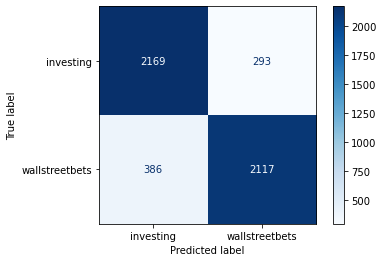

In [8]:
plot_confusion_matrix(mnb_gs, X_validation, y_validation, cmap='Blues', 
                      values_format='d', display_labels=['investing', 'wallstreetbets']);

## Random Forests

The second model I chose to run was the Random Forests. I first established the parameters I wanted to evaluate with my grid search for both the vectorizer and estimator. I then established the pipeline with the TfidfVectorizer and the RF model. I tested both the CountVectorizer and the TfidfVectorizer, but decided on using the TfidfVectorizer in conjunction with this model. I then set up my grid search utilizing 5 cross folds and used half of the cores of my computer to speed up processing.

In [9]:
rf_pipe_params = {'vec__stop_words': ['english'],
                  'vec__max_features': [32000],
                  'vec__min_df': [3],
                  'vec__max_df': [0.90],
                  'vec__ngram_range': [(1, 2)],
                  'rf__n_estimators': [100],
                  'rf__max_features': ['auto'],
                  'rf__max_depth': [None]} 

rf_pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_gs = GridSearchCV(rf_pipe,
          rf_pipe_params,
          cv=5,
          n_jobs=6,
          verbose=1)

I then fit my model using the above grid search and printed out my selection of best parameters and the best score.

In [10]:
rf_gs.fit(X_train, y_train)

print(f'Best parameters: {rf_gs.best_params_}')
print(f'Best score: {rf_gs.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   19.2s finished


Best parameters: {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 100, 'vec__max_df': 0.9, 'vec__max_features': 32000, 'vec__min_df': 3, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}
Best score: 0.864835762132555


I then generated predictions on my validation set and unraveled my true negatives, false positives, false negatives, and true positives to aid in calculating the various classification metrics.

In [11]:
rf_preds = rf_gs.predict(X_validation)

tn, fp, fn, tp = confusion_matrix(y_validation, rf_preds).ravel()

print(f'Accuracy score: {rf_gs.score(X_validation, y_validation)}.')
print(f'Specificity score: {tn / (tn+fp)}.')
print(f'Sensitivity score: {recall_score(y_validation, rf_preds)}.')
print(f'Precision score: {precision_score(y_validation, rf_preds)}.')
print(f'F1 score: {f1_score(y_validation, rf_preds)}.')

Accuracy score: 0.8580060422960725.
Specificity score: 0.8956133225020309.
Sensitivity score: 0.8210147822612864.
Precision score: 0.888840830449827.
F1 score: 0.8535825545171339.


The last part to evaluate for the Random Forests model was to look at the confusion matrix.

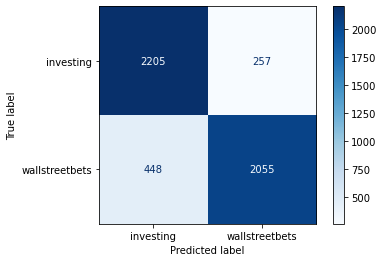

In [12]:
plot_confusion_matrix(rf_gs, X_validation, y_validation, cmap='Blues', 
                      values_format='d', display_labels=['investing', 'wallstreetbets']);

## Logistic Regression

In [13]:
lr_pipe_params = {'vec__stop_words': ['english'],
                  'vec__max_features': [36000],
                  'vec__min_df': [3],
                  'vec__max_df': [.85],
                  'vec__ngram_range': [(1, 2)],
                  'lr__C': [.1]}

lr_pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])

lr_gs = GridSearchCV(lr_pipe,
          lr_pipe_params,
          cv=5,
          n_jobs=6,
          verbose=1)

In [14]:
lr_gs.fit(X_train, y_train)

print(f'Best parameters: {lr_gs.best_params_}')
print(f'Best score: {lr_gs.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.3s finished


Best parameters: {'lr__C': 0.1, 'vec__max_df': 0.85, 'vec__max_features': 36000, 'vec__min_df': 3, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}
Best score: 0.8699394305019847


In [15]:
lr_preds = lr_gs.predict(X_validation)

tn, fp, fn, tp = confusion_matrix(y_validation, lr_preds).ravel()

print(f'Accuracy score: {lr_gs.score(X_validation, y_validation)}.')
print(f'Specificity score: {tn / (tn+fp)}.')
print(f'Sensitivity score: {recall_score(y_validation, lr_preds)}.')
print(f'Precision score: {precision_score(y_validation, lr_preds)}.')
print(f'F1 score: {f1_score(y_validation, lr_preds)}.')

Accuracy score: 0.8652567975830816.
Specificity score: 0.8623070674248579.
Sensitivity score: 0.8681582101478226.
Precision score: 0.865047770700637.
F1 score: 0.8666001994017946.


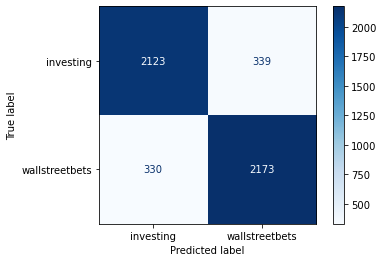

In [16]:
plot_confusion_matrix(lr_gs, X_validation, y_validation, cmap='Blues', 
                      values_format='d', display_labels=['investing', 'wallstreetbets']);

## Model Comparison

When comparing my two final models, it is important to first clarify which classification metric I was looking to optimize. Even though my specificity and precision scores were the highest, I felt it was important to maximize my sensitivity or recall score based on the nature of my problem statement, the subreddits I chose, and the data. Considering I was trying to determine whether a post would be classified as something meant more as an investment (less speculative) or as a 'bet' (more speculative), it is safer to classify 'investment' posts as 'bets' incorrectly (false positives) rather than considering a risky or speculative bet as a safe investment incorrectly (false negatives). This increases the overall number of true positives while keeping the same number of all positives equal.

With that in mind, the Logistic Regression model performed better than the Multinomial Naive Bayes and Random Forests models. The LogReg model scored 0.868 for sensitivity while the NB model and RF model scored 0.846 and 0.821, respectively.